<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/MRC_Practice_5_Dense_Passage_Retrieval_(In_batch)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5강) BERT를 활용한 Dense Passage Retrieval 실습

### Requirements

In [1]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 290 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 243 kB 39.8 MB/s 
     |████████████████████████████████| 125 kB 47.1 MB/s 
     |████████████████████████████████| 1.3 MB 32.3 MB/s 
     |████████████████████████████████| 160 kB 47.7 MB/s 
     |████████████████████████████████| 271 kB 50.5 MB/s 
     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 3.3 MB 47.2 MB/s 
     |████████████████████████████████| 895 kB 41.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 데이터셋 로딩


KorQuAD train 데이터셋을 학습 데이터로 활용

In [2]:
from datasets import load_dataset

dataset = load_dataset("squad_kor_v1")

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/7.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/770k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad_kor_v1 downloaded and prepared to /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/18d4f44736b8ee85671f63cb84965bfb583fa0a4ff2df3c2e10eee9693796725. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## 토크나이저 준비 - Huggingface 제공 tokenizer 이용

BERT를 encoder로 사용하므로, hugginface에서 제공하는 "bert-base-multilingual-cased" tokenizer를 활용

In [3]:
from transformers import AutoTokenizer
import numpy as np

model_checkpoint = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [5]:
tokenized_input = tokenizer(dataset['train'][0]['context'], padding="max_length", truncation=True)
tokenizer.decode(tokenized_input['input_ids'])

'[CLS] 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 [UNK] 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡 ( 1악장 ) 을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## Dense encoder (BERT) 학습 시키기

HuggingFace BERT를 활용하여 question encoder, passage encoder 학습

In [6]:
from tqdm import tqdm, trange
import argparse
import random
import torch
import torch.nn.functional as F
from transformers import BertModel, BertPreTrainedModel, AdamW, TrainingArguments, get_linear_schedule_with_warmup

torch.manual_seed(2021)
torch.cuda.manual_seed(2021)
np.random.seed(2021)
random.seed(2021)

1) Training Dataset 준비하기 (question, passage pairs)

---



In [7]:
# Use subset (128 example) of original training dataset 
sample_idx = np.random.choice(range(len(dataset['train'])), 128)
print(f"sample_idx is {sample_idx}")
training_dataset = dataset['train'][sample_idx]

sample_idx is [25716 27989  6201 17536  2669 20318 22486 30764 22015 25406 16347 21149
 32277 51549 47256 23948 23030 49350 35942 36934  4641 47717 34567 41217
 38254 38369 46460 30437 24986 32450 35760 11747 36927 34353 27280 14002
 39734 53627 26036 30557 51832 30001  3494 53063 36181 41030  8361 44565
 17654 31769 38794 34468  6509  8042 44051 44217 42066 34522 27535 33320
 49130 38860  6965 42507 49555 54177 42830 34833 54617 27826 25607 33013
 37363 23067 18668 45175  8639 53171 23305 15972 48617  9575 35353 43463
   999  4692  3227   765 48795 13587 42655 18738 34030   345 48539 59317
 23666 49146 11040 16788 57823  8791 55683 48865 54804 49298 53107 59494
  2630  8561 36186 38581 16618 53566 31965 37295 32219  3719 55261 49697
  3493 32991 31470 13758 24672 38516 35375 57373]


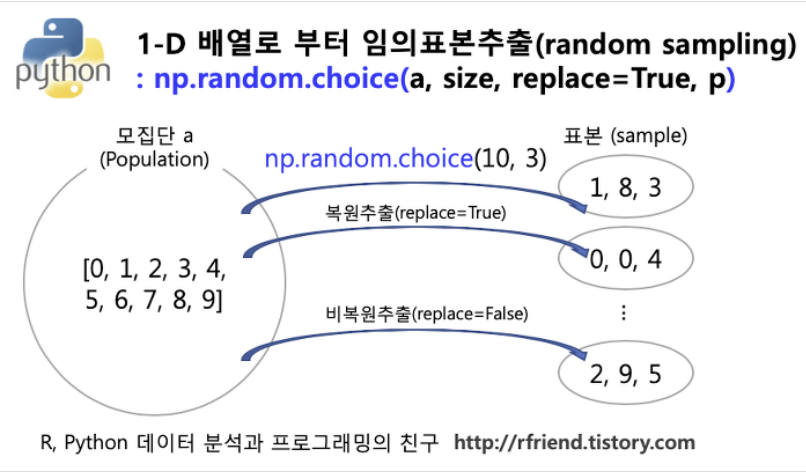

In [8]:
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)

q_seqs = tokenizer(training_dataset['question'], padding="max_length", truncation=True, return_tensors='pt')
p_seqs = tokenizer(training_dataset['context'], padding="max_length", truncation=True, return_tensors='pt')


In [9]:
train_dataset = TensorDataset(p_seqs['input_ids'], p_seqs['attention_mask'], p_seqs['token_type_ids'], 
                        q_seqs['input_ids'], q_seqs['attention_mask'], q_seqs['token_type_ids'])

2) BERT encoder 학습시키기

BertEncoder 모델 정의 후, question encoder, passage encoder에 pre-trained weight 불러오기

In [ ]:
class BertEncoder(BertPreTrainedModel):
  def __init__(self, config):
    super(BertEncoder, self).__init__(config)

    self.bert = BertModel(config)
    self.init_weights()
      
  def forward(self, input_ids, 
              attention_mask=None, token_type_ids=None): 
  
      outputs = self.bert(input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
      
      pooled_output = outputs[1]

      return pooled_output


https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel

In [ ]:
# load pre-trained model on cuda (if available)
p_encoder = BertEncoder.from_pretrained(model_checkpoint)
q_encoder = BertEncoder.from_pretrained(model_checkpoint)

if torch.cuda.is_available():
  p_encoder.cuda()
  q_encoder.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertEncoder: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertEncoder: ['cls.predictions.bias',

Train function 정의 후, 두개의 encoder fine-tuning 하기 (In-batch negative 활용) 


In [ ]:
def train(args, dataset, p_model, q_model):
  
  # Dataloader
  train_sampler = RandomSampler(dataset)
  train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=args.per_device_train_batch_size)

tt
  t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total)

  # Start training!
  global_step = 0
  
  p_model.zero_grad()
  q_model.zero_grad()
  torch.cuda.empty_cache()
  
  train_iterator = trange(int(args.num_train_epochs), desc="Epoch")

  for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")

    for step, batch in enumerate(epoch_iterator):
      q_encoder.train()
      p_encoder.train()
      
      if torch.cuda.is_available():
        batch = tuple(t.cuda() for t in batch)

      p_inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2]
                  }
      
      q_inputs = {'input_ids': batch[3],
                  'attention_mask': batch[4],
                  'token_type_ids': batch[5]}
      
      p_outputs = p_model(**p_inputs)  # (batch_size, emb_dim)
      q_outputs = q_model(**q_inputs)  # (batch_size, emb_dim)


      # Calculate similarity score & loss
      sim_scores = torch.matmul(q_outputs, torch.transpose(p_outputs, 0, 1))  # (batch_size, emb_dim) x (emb_dim, batch_size) = (batch_size, batch_size)

      # target: position of positive samples = diagonal element 
      targets = torch.arange(0, args.per_device_train_batch_size).long()
      if torch.cuda.is_available():
        targets = targets.to('cuda')

      sim_scores = F.log_softmax(sim_scores, dim=1)

      loss = F.nll_loss(sim_scores, targets)
      print(loss)

      loss.backward()
      optimizer.step()
      scheduler.step()
      q_model.zero_grad()
      p_model.zero_grad()
      global_step += 1
      
      torch.cuda.empty_cache()


    
  return p_model, q_model




In [ ]:
args = TrainingArguments(
    output_dir="dense_retireval",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01
)


In [ ]:
p_encoder, q_encoder = train(args, train_dataset, p_encoder, q_encoder)

Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

tensor(32.2463, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   3%|▎         | 1/32 [00:01<00:33,  1.07s/it]

tensor(7.5171, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   6%|▋         | 2/32 [00:02<00:32,  1.08s/it]

tensor(11.6010, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   9%|▉         | 3/32 [00:03<00:31,  1.08s/it]

tensor(3.4258, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  12%|█▎        | 4/32 [00:04<00:30,  1.08s/it]

tensor(2.3988, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  16%|█▌        | 5/32 [00:05<00:29,  1.08s/it]

tensor(1.5510, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  19%|█▉        | 6/32 [00:06<00:28,  1.08s/it]

tensor(3.1626, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  22%|██▏       | 7/32 [00:07<00:27,  1.08s/it]

tensor(1.9077, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  25%|██▌       | 8/32 [00:08<00:26,  1.09s/it]

tensor(2.8511, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  28%|██▊       | 9/32 [00:09<00:25,  1.09s/it]

tensor(2.2383, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  31%|███▏      | 10/32 [00:10<00:24,  1.09s/it]

tensor(1.5784, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  34%|███▍      | 11/32 [00:11<00:22,  1.09s/it]

tensor(1.4731, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  38%|███▊      | 12/32 [00:13<00:21,  1.09s/it]

tensor(1.3120, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  41%|████      | 13/32 [00:14<00:20,  1.09s/it]

tensor(1.7495, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  44%|████▍     | 14/32 [00:15<00:19,  1.10s/it]

tensor(2.0397, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  47%|████▋     | 15/32 [00:16<00:18,  1.10s/it]

tensor(2.2702, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  50%|█████     | 16/32 [00:17<00:17,  1.11s/it]

tensor(1.6097, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  53%|█████▎    | 17/32 [00:18<00:16,  1.11s/it]

tensor(1.3690, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  56%|█████▋    | 18/32 [00:19<00:15,  1.11s/it]

tensor(1.4093, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  59%|█████▉    | 19/32 [00:20<00:14,  1.11s/it]

tensor(1.4360, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  62%|██████▎   | 20/32 [00:21<00:13,  1.11s/it]

tensor(2.0589, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  66%|██████▌   | 21/32 [00:23<00:12,  1.11s/it]

tensor(1.7093, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  69%|██████▉   | 22/32 [00:24<00:11,  1.12s/it]

tensor(2.0336, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  72%|███████▏  | 23/32 [00:25<00:10,  1.13s/it]

tensor(1.3478, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  75%|███████▌  | 24/32 [00:26<00:09,  1.13s/it]

tensor(1.1512, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  78%|███████▊  | 25/32 [00:27<00:07,  1.14s/it]

tensor(2.0699, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  81%|████████▏ | 26/32 [00:28<00:06,  1.15s/it]

tensor(1.3971, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  84%|████████▍ | 27/32 [00:29<00:05,  1.15s/it]

tensor(1.8141, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  88%|████████▊ | 28/32 [00:31<00:04,  1.16s/it]

tensor(1.5161, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  91%|█████████ | 29/32 [00:32<00:03,  1.16s/it]

tensor(1.3845, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  94%|█████████▍| 30/32 [00:33<00:02,  1.16s/it]

tensor(2.3735, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  97%|█████████▋| 31/32 [00:34<00:01,  1.17s/it]

tensor(1.5397, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

tensor(1.4117, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   3%|▎         | 1/32 [00:01<00:36,  1.18s/it]

tensor(1.4532, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   6%|▋         | 2/32 [00:02<00:35,  1.17s/it]

tensor(1.4826, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:   9%|▉         | 3/32 [00:03<00:34,  1.18s/it]

tensor(2.6323, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  12%|█▎        | 4/32 [00:04<00:32,  1.17s/it]

tensor(1.3588, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  16%|█▌        | 5/32 [00:05<00:31,  1.17s/it]

tensor(0.7726, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  19%|█▉        | 6/32 [00:07<00:30,  1.17s/it]

tensor(1.0932, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  22%|██▏       | 7/32 [00:08<00:29,  1.16s/it]

tensor(1.9153, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  25%|██▌       | 8/32 [00:09<00:27,  1.16s/it]

tensor(1.3555, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  28%|██▊       | 9/32 [00:10<00:26,  1.16s/it]

tensor(1.7998, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  31%|███▏      | 10/32 [00:11<00:25,  1.15s/it]

tensor(1.5003, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  34%|███▍      | 11/32 [00:12<00:24,  1.14s/it]

tensor(1.5269, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  38%|███▊      | 12/32 [00:13<00:22,  1.14s/it]

tensor(1.3826, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  41%|████      | 13/32 [00:15<00:21,  1.14s/it]

tensor(1.5955, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  44%|████▍     | 14/32 [00:16<00:20,  1.14s/it]

tensor(1.5773, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  47%|████▋     | 15/32 [00:17<00:19,  1.13s/it]

tensor(1.4181, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  50%|█████     | 16/32 [00:18<00:18,  1.13s/it]

tensor(1.5239, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  53%|█████▎    | 17/32 [00:19<00:16,  1.12s/it]

tensor(1.4001, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  56%|█████▋    | 18/32 [00:20<00:15,  1.12s/it]

tensor(1.5998, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  59%|█████▉    | 19/32 [00:21<00:14,  1.12s/it]

tensor(1.7401, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  62%|██████▎   | 20/32 [00:22<00:13,  1.12s/it]

tensor(1.4382, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  66%|██████▌   | 21/32 [00:23<00:12,  1.11s/it]

tensor(1.5681, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  69%|██████▉   | 22/32 [00:25<00:11,  1.11s/it]

tensor(1.5597, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  72%|███████▏  | 23/32 [00:26<00:09,  1.11s/it]

tensor(1.3345, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  75%|███████▌  | 24/32 [00:27<00:08,  1.11s/it]

tensor(1.2730, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  78%|███████▊  | 25/32 [00:28<00:07,  1.11s/it]

tensor(1.7631, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  81%|████████▏ | 26/32 [00:29<00:06,  1.11s/it]

tensor(1.8818, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  84%|████████▍ | 27/32 [00:30<00:05,  1.10s/it]

tensor(2.7091, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  88%|████████▊ | 28/32 [00:31<00:04,  1.10s/it]

tensor(1.5078, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  91%|█████████ | 29/32 [00:32<00:03,  1.11s/it]

tensor(1.3712, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  94%|█████████▍| 30/32 [00:33<00:02,  1.11s/it]

tensor(1.4023, device='cuda:0', grad_fn=<NllLossBackward>)



Iteration:  97%|█████████▋| 31/32 [00:35<00:01,  1.11s/it]

tensor(1.5262, device='cuda:0', grad_fn=<NllLossBackward>)



Epoch: 100%|██████████| 2/2 [01:11<00:00, 35.99s/it]


## Dense Embedding을 활용하여 passage retrieval 실습해보기

In [ ]:

valid_corpus = list(set([example['context'] for example in dataset['validation']]))[:10]
sample_idx = random.choice(range(len(dataset['validation'])))
query = dataset['validation'][sample_idx]['question']
ground_truth = dataset['validation'][sample_idx]['context']

if not ground_truth in valid_corpus:
  valid_corpus.append(ground_truth)

print(query)
print(ground_truth, '\n\n')

# valid_corpus

유아인에게 타고난 배우라고 말한 드라마 밀회의 감독은?
화보 촬영을 위해 미국에 있을 때, 김희애의 연락을 통해 JTBC 드라마 《밀회》의 캐스팅을 제안받았다. 당시 영화 《베테랑》에 이미 캐스팅된 상태였으나, 유아인은 류승완 감독과 제작사의 양해를 얻어 《밀회》에 출연한다. 천재 피아니스트 ‘이선재’ 역할을 위해 피아니스트들의 영상을 보고 곡의 스피드와 건반 위치 등을 외워 실제 타건을 하며 촬영했다. 피아노 울림판을 수건으로 막고 타건을 하면, 그 후 대역 피아니스트의 소리를 덧입히는 방식이었다. 《밀회》는 작품성을 인정받고 숱한 화제를 낳으며 당시 종편으로서는 높은 시청률을 기록했다. 유아인은 섬세한 연기력을 선보여 순수함으로 시청자들을 매료시켰다는 호평을 얻었고, 특히 피아노 연주에 있어서 클래식 종사자들에게 인정을 받았다. 연출을 맡은 안판석 감독은 유아인에 대해 “느낌으로만 연기를 하는 게 아니고 감성을 지적으로 통제해 가면서 연기한다. 그 나이에”라며 “타고난 배우”라고 말했다. 유아인은 《밀회》를 통해 예술적인 면모를 구체화할 수 있어서 만족감을 느꼈다고 밝혔으며, 종영 후 자신의 페이스북 계정에 긴 소감글을 남겼다. 특히 ‘이선재’ 캐릭터를 배우 유아인이 가진 소년성의 엑기스로 생각하며, 2015년 10월 부산국제영화제 오픈토크에서는 본인이 가장 좋아하는 캐릭터로 꼽았다. 




앞서 학습한 passage encoder, question encoder을 이용해 dense embedding 생성

In [ ]:
def to_cuda(batch):
  return tuple(t.cuda() for t in batch)

In [ ]:
with torch.no_grad():
  p_encoder.eval()
  q_encoder.eval()

  q_seqs_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt').to('cuda')
  q_emb = q_encoder(**q_seqs_val).to('cpu')  #(num_query, emb_dim)

  p_embs = []
  for p in valid_corpus:
    p = tokenizer(p, padding="max_length", truncation=True, return_tensors='pt').to('cuda')
    p_emb = p_encoder(**p).to('cpu').numpy()
    p_embs.append(p_emb)

p_embs = torch.Tensor(p_embs).squeeze()  # (num_passage, emb_dim)

print(p_embs.size(), q_emb.size())

torch.Size([11, 768]) torch.Size([1, 768])


11->이건, passage embedding matrix크기(10+1(question))
1 ->이건 question 개수
768 -> 이건 embedding size

생성된 embedding에 dot product를 수행 => Document들의 similarity ranking을 구함

In [ ]:
dot_prod_scores = torch.matmul(q_emb, torch.transpose(p_embs, 0, 1))
print(dot_prod_scores.size())

rank = torch.argsort(dot_prod_scores, dim=1, descending=True).squeeze()
print(dot_prod_scores)
print(rank)

torch.Size([1, 11])
tensor([[22.0175, 22.0863, 21.9051, 21.7622, 22.2768, 22.1047, 21.9458, 22.1937,
         22.1052, 22.4834, 22.4642]])
tensor([ 9, 10,  4,  7,  8,  5,  1,  0,  6,  2,  3])


torch.Size([1,11]) 은 11개 문서에 대한 유사도점수를 각각 dimension이 담고 있다<br>
argsort로 rank를 매긴다


Top-5개의 passage를 retrieve 하고 ground truth와 비교하기

In [ ]:
k = 5
print("[Search query]\n", query, "\n")
print("[Ground truth passage]")
print(ground_truth, "\n")

for i in range(k):
  print("Top-%d passage with score %.4f" % (i+1, dot_prod_scores.squeeze()[rank[i]]))
  print(valid_corpus[rank[i]])

[Search query]
 유아인에게 타고난 배우라고 말한 드라마 밀회의 감독은? 

[Ground truth passage]
화보 촬영을 위해 미국에 있을 때, 김희애의 연락을 통해 JTBC 드라마 《밀회》의 캐스팅을 제안받았다. 당시 영화 《베테랑》에 이미 캐스팅된 상태였으나, 유아인은 류승완 감독과 제작사의 양해를 얻어 《밀회》에 출연한다. 천재 피아니스트 ‘이선재’ 역할을 위해 피아니스트들의 영상을 보고 곡의 스피드와 건반 위치 등을 외워 실제 타건을 하며 촬영했다. 피아노 울림판을 수건으로 막고 타건을 하면, 그 후 대역 피아니스트의 소리를 덧입히는 방식이었다. 《밀회》는 작품성을 인정받고 숱한 화제를 낳으며 당시 종편으로서는 높은 시청률을 기록했다. 유아인은 섬세한 연기력을 선보여 순수함으로 시청자들을 매료시켰다는 호평을 얻었고, 특히 피아노 연주에 있어서 클래식 종사자들에게 인정을 받았다. 연출을 맡은 안판석 감독은 유아인에 대해 “느낌으로만 연기를 하는 게 아니고 감성을 지적으로 통제해 가면서 연기한다. 그 나이에”라며 “타고난 배우”라고 말했다. 유아인은 《밀회》를 통해 예술적인 면모를 구체화할 수 있어서 만족감을 느꼈다고 밝혔으며, 종영 후 자신의 페이스북 계정에 긴 소감글을 남겼다. 특히 ‘이선재’ 캐릭터를 배우 유아인이 가진 소년성의 엑기스로 생각하며, 2015년 10월 부산국제영화제 오픈토크에서는 본인이 가장 좋아하는 캐릭터로 꼽았다. 

Top-1 passage with score 22.4834
2010년 4월에는 유럽발 재정위기가 발생하면서 또 한 번 세계경제는 대침체에 빠졌다. 또한 2011년 8월에는 S&P에 의해 미국의 국가신용등급이 강등되면서 세계 경제는 또 한 번의 충격에 빠졌다. 이에 중국, 일본과 맺은 통화스와프를 확대하고 균형재정을 선언하는 등 위기극복에 나섰다. 그 결과 한국은 2012년 8월 무디스, 피치, S&P등 3대 신용평가사로부터 사상 최고의 국가신용등급을 받았고, 특히 피치로부터 받은 국가신용등급은 사상 